In [79]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import re

C:\Users\devin\AppData\Local\Temp\ipykernel_20316\368733898.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Import and Clean Data

In [34]:
data = pd.read_excel('data/FFN_History_data.xlsx')

In [35]:
data.dropna(subset=['Name'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [36]:
data

,ID,Name,League,Year,League Year #,Rank,Sport,Minigame?,Dynasty?,Bestball?,Orphaned?
0,112.0,Grant,FFN Alumni,2021,1,1.0,Football,0,1,0,0
1,109.0,Ari,FFN Alumni,2021,1,2.0,Football,0,1,0,0
2,103.0,Cam,FFN Alumni,2021,1,3.0,Football,0,1,0,0
3,106.0,Kyle,FFN Alumni,2021,1,4.0,Football,0,1,0,0
4,127.0,DMac,FFN Alumni,2021,1,5.0,Football,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
520,102.0,Devin,NHL Bracket Challenge,2024,1,2.0,Hockey,1,0,0,0
521,125.0,Soup,NHL Bracket Challenge,2024,1,3.0,Hockey,1,0,0,0
522,105.0,Graham,NHL Bracket Challenge,2024,1,4.0,Hockey,1,0,0,0
523,164.0,Noah,NHL Bracket Challenge,2024,1,5.0,Hockey,1,0,0,0


## Compute Total Number of Participants in Each Contest

In [37]:
# Calculate the total number of unique participants in each league per year
total_players = data.groupby(['League', 'Year'])['ID'].nunique().reset_index(name='Total Players')

# Merge the total_players with the original dataframe to add the Total Players column
data_merged = pd.merge(data, total_players, how='left', on=['League', 'Year'])

data_merged.tail()

,ID,Name,League,Year,League Year #,Rank,Sport,Minigame?,Dynasty?,Bestball?,Orphaned?,Total Players
520,102.0,Devin,NHL Bracket Challenge,2024,1,2.0,Hockey,1,0,0,0,6
521,125.0,Soup,NHL Bracket Challenge,2024,1,3.0,Hockey,1,0,0,0,6
522,105.0,Graham,NHL Bracket Challenge,2024,1,4.0,Hockey,1,0,0,0,6
523,164.0,Noah,NHL Bracket Challenge,2024,1,5.0,Hockey,1,0,0,0,6
524,159.0,Quinn,NHL Bracket Challenge,2024,1,6.0,Hockey,1,0,0,0,6


In [38]:
# Update the Data DataFrame to reflect the total players results
data['Total Players'] = data_merged['Total Players']

# Find the largest Rank in each league-year combination
largest_rank = data.groupby(['League', 'Year'])['Rank'].max().reset_index(name='Largest Rank')

# Merge this back with the original DataFrame
data_with_largest_rank = pd.merge(data, largest_rank, how='left', on=['League', 'Year'])

# Update the 'Total Players' column based on the largest rank exceeding the current total players value
data_with_largest_rank['Total Players'] = data_with_largest_rank.apply(
    lambda row: max(row['Total Players'], row['Largest Rank']), axis=1
)

# Dropping the 'Largest Rank' column as it's no longer needed
data_with_largest_rank.drop(columns=['Largest Rank'], inplace=True)

data_with_largest_rank.tail()  # Displaying the last few rows to verify the update

,ID,Name,League,Year,League Year #,Rank,Sport,Minigame?,Dynasty?,Bestball?,Orphaned?,Total Players
520,102.0,Devin,NHL Bracket Challenge,2024,1,2.0,Hockey,1,0,0,0,6.0
521,125.0,Soup,NHL Bracket Challenge,2024,1,3.0,Hockey,1,0,0,0,6.0
522,105.0,Graham,NHL Bracket Challenge,2024,1,4.0,Hockey,1,0,0,0,6.0
523,164.0,Noah,NHL Bracket Challenge,2024,1,5.0,Hockey,1,0,0,0,6.0
524,159.0,Quinn,NHL Bracket Challenge,2024,1,6.0,Hockey,1,0,0,0,6.0


In [39]:
# Update the Data DataFrame to reflect the total players results
data['Total Players'] = data_with_largest_rank['Total Players']

In [40]:
data

,ID,Name,League,Year,League Year #,Rank,Sport,Minigame?,Dynasty?,Bestball?,Orphaned?,Total Players
0,112.0,Grant,FFN Alumni,2021,1,1.0,Football,0,1,0,0,12.0
1,109.0,Ari,FFN Alumni,2021,1,2.0,Football,0,1,0,0,12.0
2,103.0,Cam,FFN Alumni,2021,1,3.0,Football,0,1,0,0,12.0
3,106.0,Kyle,FFN Alumni,2021,1,4.0,Football,0,1,0,0,12.0
4,127.0,DMac,FFN Alumni,2021,1,5.0,Football,0,1,0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...
520,102.0,Devin,NHL Bracket Challenge,2024,1,2.0,Hockey,1,0,0,0,6.0
521,125.0,Soup,NHL Bracket Challenge,2024,1,3.0,Hockey,1,0,0,0,6.0
522,105.0,Graham,NHL Bracket Challenge,2024,1,4.0,Hockey,1,0,0,0,6.0
523,164.0,Noah,NHL Bracket Challenge,2024,1,5.0,Hockey,1,0,0,0,6.0


## Compute Adjusted Percentile

### In order to account for the difference in competition size, an adjusted percentile needs to be implemented based on the following formula:

$$
\text{Adjusted Percentile} = \left( \frac{n - \text{rank}}{n - 1} \right) \cdot \ln(1 + n)
$$

where:

- $\text{rank}$ is the position of an individual within the league, with 1 being the highest position.
- $n$ is the total number of participants in the league.


In [41]:
# Define the function to calculate Adjusted Percentile
def calculate_adjusted_percentile(row):
    n = row['Total Players']
    rank = row['Rank']
    if n > 1:
        adjusted_percentile = ((n - rank) / (n - 1)) * np.log(1 + n)
    else:
        adjusted_percentile = np.log(2)  # When there's only one player, use log(2) as a placeholder
    return adjusted_percentile

In [42]:
# Define the function to calculate the Perfect Adjusted Percentile
def calculate_perfect_adjusted_percentile(row):
    n = row['Total Players']
    # Ideal scenario: player always ranks 1st
    ideal_rank = 1
    if n > 1:
        perfect_adjusted_percentile = ((n - ideal_rank) / (n - 1)) * np.log(1 + n)
    else:
        perfect_adjusted_percentile = np.log(2)  # When there's only one league, use log(2) as a placeholder
    return perfect_adjusted_percentile

In [43]:
# Apply the function to compute Adjusted Percentile for each row
data['Adjusted Percentile'] = data.apply(calculate_adjusted_percentile, axis=1)
data['Perfect Adjusted Percentile'] = data.apply(calculate_perfect_adjusted_percentile, axis=1)

data.head()

,ID,Name,League,Year,League Year #,Rank,Sport,Minigame?,Dynasty?,Bestball?,Orphaned?,Total Players,Adjusted Percentile,Perfect Adjusted Percentile
0,112.0,Grant,FFN Alumni,2021,1,1.0,Football,0,1,0,0,12.0,2.564949,2.564949
1,109.0,Ari,FFN Alumni,2021,1,2.0,Football,0,1,0,0,12.0,2.331772,2.564949
2,103.0,Cam,FFN Alumni,2021,1,3.0,Football,0,1,0,0,12.0,2.098595,2.564949
3,106.0,Kyle,FFN Alumni,2021,1,4.0,Football,0,1,0,0,12.0,1.865418,2.564949
4,127.0,DMac,FFN Alumni,2021,1,5.0,Football,0,1,0,0,12.0,1.632241,2.564949


# Create Summary Statistics for Each Player

### For the summary statistics, the data can be filtered to compute the results of various subsets of the overall dataset. The function below is implemented to handle such filtering and documentation is provided below as well

In [44]:
# Function to filter the DataFrame based on various column criteria
def filter_dataframe(df, ID=None, Name=None, League=None, Year=None, League_Year_Number=None, 
                     Rank=None, Sport=None, Minigame=None, Dynasty=None, Bestball=None, 
                     Orphaned=None, Total_Players=None, Adjusted_Percentile=None):
    filtered_df = df.copy()
    
    if ID is not None:
        filtered_df = filtered_df[filtered_df['ID'] == ID]
    if Name is not None:
        filtered_df = filtered_df[filtered_df['Name'] == Name]
    if League is not None:
        filtered_df = filtered_df[filtered_df['League'] == League]
    if Year is not None:
        filtered_df = filtered_df[filtered_df['Year'] == Year]
    if League_Year_Number is not None:
        filtered_df = filtered_df[filtered_df['League Year #'] == League_Year_Number]
    if Rank is not None:
        filtered_df = filtered_df[filtered_df['Rank'] == Rank]
    if Sport is not None:
        filtered_df = filtered_df[filtered_df['Sport'] == Sport]
    if Minigame is not None:
        filtered_df = filtered_df[filtered_df['Minigame?'] == Minigame]
    if Dynasty is not None:
        filtered_df = filtered_df[filtered_df['Dynasty?'] == Dynasty]
    if Bestball is not None:
        filtered_df = filtered_df[filtered_df['Bestball?'] == Bestball]
    if Orphaned is not None:
        filtered_df = filtered_df[filtered_df['Orphaned?'] == Orphaned]
    if Total_Players is not None:
        filtered_df = filtered_df[filtered_df['Total Players'] == Total_Players]
    if Adjusted_Percentile is not None:
        # Adjusted Percentile might need a range or exact match, here it's considered as exact match for simplicity
        filtered_df = filtered_df[filtered_df['Adjusted Percentile'] == Adjusted_Percentile]
    
    return filtered_df

In [ ]:
"""
Function Usage Example:

The `filter_dataframe` function can be used to filter the data based on various criteria.
Each parameter corresponds to a column in the DataFrame, and you can specify filters for any combination of these columns.
If a parameter is not specified (left as None), no filter is applied for that column.

Parameters:
ID: Filter by the unique ID of the participant (e.g., 112.0)
Name: Filter by the participant's name (e.g., 'Grant')
League: Filter by the league name (e.g., 'FFN Alumni')
Year: Filter by the year of the league (e.g., 2021)
League_Year_Number: Filter by the specific league year number (e.g., 1)
Rank: Filter by the rank within the league (e.g., 1.0 for first place)
Sport: Filter by the sport type (e.g., 'Football')
Minigame: Filter by whether it is a minigame (1 for yes, 0 for no)
Dynasty: Filter by whether it is a dynasty league (1 for yes, 0 for no)
Bestball: Filter by whether it is a bestball league (1 for yes, 0 for no)
Orphaned: Filter by whether the team was orphaned (1 for yes, 0 for no)
Total_Players: Filter by the total number of players in the league (e.g., 12)
Adjusted_Percentile: Filter by the adjusted percentile score (e.g., 2.564949)
""";
# Example:
# To filter the data for leagues from the year 2021 that are in the sport of Football, use the following:
# filtered_data = filter_dataframe(data, Year=2021, Sport='Football')
# filtered_data.head()

In [45]:
filtered_data = filter_dataframe(data, Orphaned=0)
filtered_data.reset_index(drop=True, inplace=True)
filtered_data.head()

,ID,Name,League,Year,League Year #,Rank,Sport,Minigame?,Dynasty?,Bestball?,Orphaned?,Total Players,Adjusted Percentile,Perfect Adjusted Percentile
0,112.0,Grant,FFN Alumni,2021,1,1.0,Football,0,1,0,0,12.0,2.564949,2.564949
1,109.0,Ari,FFN Alumni,2021,1,2.0,Football,0,1,0,0,12.0,2.331772,2.564949
2,103.0,Cam,FFN Alumni,2021,1,3.0,Football,0,1,0,0,12.0,2.098595,2.564949
3,106.0,Kyle,FFN Alumni,2021,1,4.0,Football,0,1,0,0,12.0,1.865418,2.564949
4,127.0,DMac,FFN Alumni,2021,1,5.0,Football,0,1,0,0,12.0,1.632241,2.564949


### League Performance Index (LPI) quantifies a player's bayesian average adjusted percentile finish. Each player's adjusted percentile finish across all of their league ranking results is computed to account for the variation in the total number of players in a given league. Based on a player's total adjusted percentile finish, the bayesian average is then calculated to account for the variation in the total number of leagues a given player has participated in. 

#### Function to generate summary statistics for each player

In [46]:
def summarize_player_statistics(df):
    # Aggregate basic statistics
    player_summary = df.groupby(['ID', 'Name']).agg(
        Average_Rank=('Rank', 'mean'),
        Total_Adjusted_Percentile=('Adjusted Percentile', 'sum'),
        Average_Adjusted_Percentile=('Adjusted Percentile', 'mean'),
        Total_Perfect_Adjusted_Percentile=('Perfect Adjusted Percentile', 'sum'),
        Average_Perfect_Adjusted_Percentile=('Perfect Adjusted Percentile', 'mean')
    ).reset_index()
    
    # Ratio of player's average to perfect adjusted percentile
    player_summary['Adjusted_Percentile_Ratio'] = player_summary['Average_Adjusted_Percentile'] / player_summary['Average_Perfect_Adjusted_Percentile']
    
    # Correcting Total Leagues to simply count the number of times an ID/Name combination appears in the DataFrame
    player_summary['Total_Leagues'] = df.groupby(['ID', 'Name']).size().reset_index(name='Total_Leagues')['Total_Leagues']
    
    # Calculate C as the average of the Total_Leagues column
    C = player_summary['Total_Leagues'].mean()

    # Calculate the overall mean score (M) across all players
    M = player_summary['Average_Adjusted_Percentile'].mean()
    
    # Calculate Bayesian average for each player
    player_summary['LPI'] = (C * M + player_summary['Total_Leagues'] * player_summary['Average_Adjusted_Percentile']) / (C + player_summary['Total_Leagues'])
    
    # Create a pivot table to count participation in each league
    league_participation = df.pivot_table(index=['ID', 'Name'], columns='League', aggfunc='size', fill_value=0)
    
    # Combine the aggregated stats and league participation into one DataFrame
    player_summary_final = pd.merge(player_summary, league_participation.reset_index(), on=['ID', 'Name'], how='left')
    
    # Adjusting the order of the columns to move Total_Leagues right after the Name column
    cols = ['ID', 'Name', 'Total_Leagues', 'Average_Rank', 'Total_Adjusted_Percentile', 'Average_Adjusted_Percentile', 'Total_Perfect_Adjusted_Percentile','Average_Perfect_Adjusted_Percentile',
            'Adjusted_Percentile_Ratio', 'LPI'] + [col for col in league_participation.columns if col not in ['ID', 'Name']]
    player_summary_final_adjusted = player_summary_final[cols]
    
    # Sort by Adjusted_Percentile_Ratio from largest to smallest
    player_summary_final_sorted = player_summary_final_adjusted.sort_values(by='LPI', ascending=False)

    return player_summary_final_sorted

# Example usage:
# player_summary_final_adjusted = summarize_player_statistics(data)
# player_summary_final_adjusted.head()


In [47]:
summary_stats_df = summarize_player_statistics(filtered_data)
summary_stats_df.head()

,ID,Name,Total_Leagues,Average_Rank,Total_Adjusted_Percentile,Average_Adjusted_Percentile,Total_Perfect_Adjusted_Percentile,Average_Perfect_Adjusted_Percentile,Adjusted_Percentile_Ratio,LPI,...,NFL Playoffs Fantasy,NFL Predict the Pick,NHL Bracket Challenge,NHL Predict The Pick,Pigskin Pick'Em,Pigskin Win Totals,Puck Redraft,Sex Havers,Stanley Cup Fantasy,dyNASTY
2,102.0,Devin,51,3.960784,83.027558,1.627991,120.953104,2.371629,0.686444,1.563665,...,1,2,1,1,2,1,2,2,3,1
41,162.0,Chad,23,3.673913,38.885781,1.690686,55.272855,2.403168,0.703524,1.552249,...,0,1,0,0,1,1,1,0,2,0
9,112.0,Grant,9,4.222222,16.294674,1.810519,23.363541,2.595949,0.697440,1.503013,...,0,0,0,0,0,0,0,0,0,0
35,156.0,Landon,11,5.181818,17.002458,1.545678,27.752149,2.522923,0.612654,1.384906,...,0,0,0,0,0,0,0,2,0,0
31,152.0,John,4,6.000000,6.987222,1.746806,10.785891,2.696473,0.647811,1.359150,...,0,0,0,0,0,0,0,0,0,0


### League Performance Index Plus (LPI+) takes a player's League Performance Index (LPI) and normalizes the number across the entire FFN universe. It then adjusts so a score of 100 is league average, and 150 is 50 percent better than the league average.

In [48]:
# Compute the average of the LPI column
overall_mean_bayesian_average = summary_stats_df['LPI'].mean()

# Calculate the scale factor to adjust the Bayesian average to a scale where the average is 100
scale_factor = 100 / overall_mean_bayesian_average

# Apply the scale factor to each player's Bayesian average to adjust it to the new scale
summary_stats_df['LPI+'] = (summary_stats_df['LPI'] * scale_factor).round(2)

# Display the DataFrame to verify the new scaled scores
summary_stats_df[['ID', 'Name', 'Total_Leagues', 'Average_Rank', 'Total_Adjusted_Percentile', 'Average_Adjusted_Percentile', 'Total_Perfect_Adjusted_Percentile','Average_Perfect_Adjusted_Percentile',
            'Adjusted_Percentile_Ratio', 'LPI', 'LPI+']].head()

,ID,Name,Total_Leagues,Average_Rank,Total_Adjusted_Percentile,Average_Adjusted_Percentile,Total_Perfect_Adjusted_Percentile,Average_Perfect_Adjusted_Percentile,Adjusted_Percentile_Ratio,LPI,LPI+
2,102.0,Devin,51,3.960784,83.027558,1.627991,120.953104,2.371629,0.686444,1.563665,131.96
41,162.0,Chad,23,3.673913,38.885781,1.690686,55.272855,2.403168,0.703524,1.552249,131.00
9,112.0,Grant,9,4.222222,16.294674,1.810519,23.363541,2.595949,0.697440,1.503013,126.84
35,156.0,Landon,11,5.181818,17.002458,1.545678,27.752149,2.522923,0.612654,1.384906,116.88
31,152.0,John,4,6.000000,6.987222,1.746806,10.785891,2.696473,0.647811,1.359150,114.70


## Plot of League Performance Index Plus (LPI+)

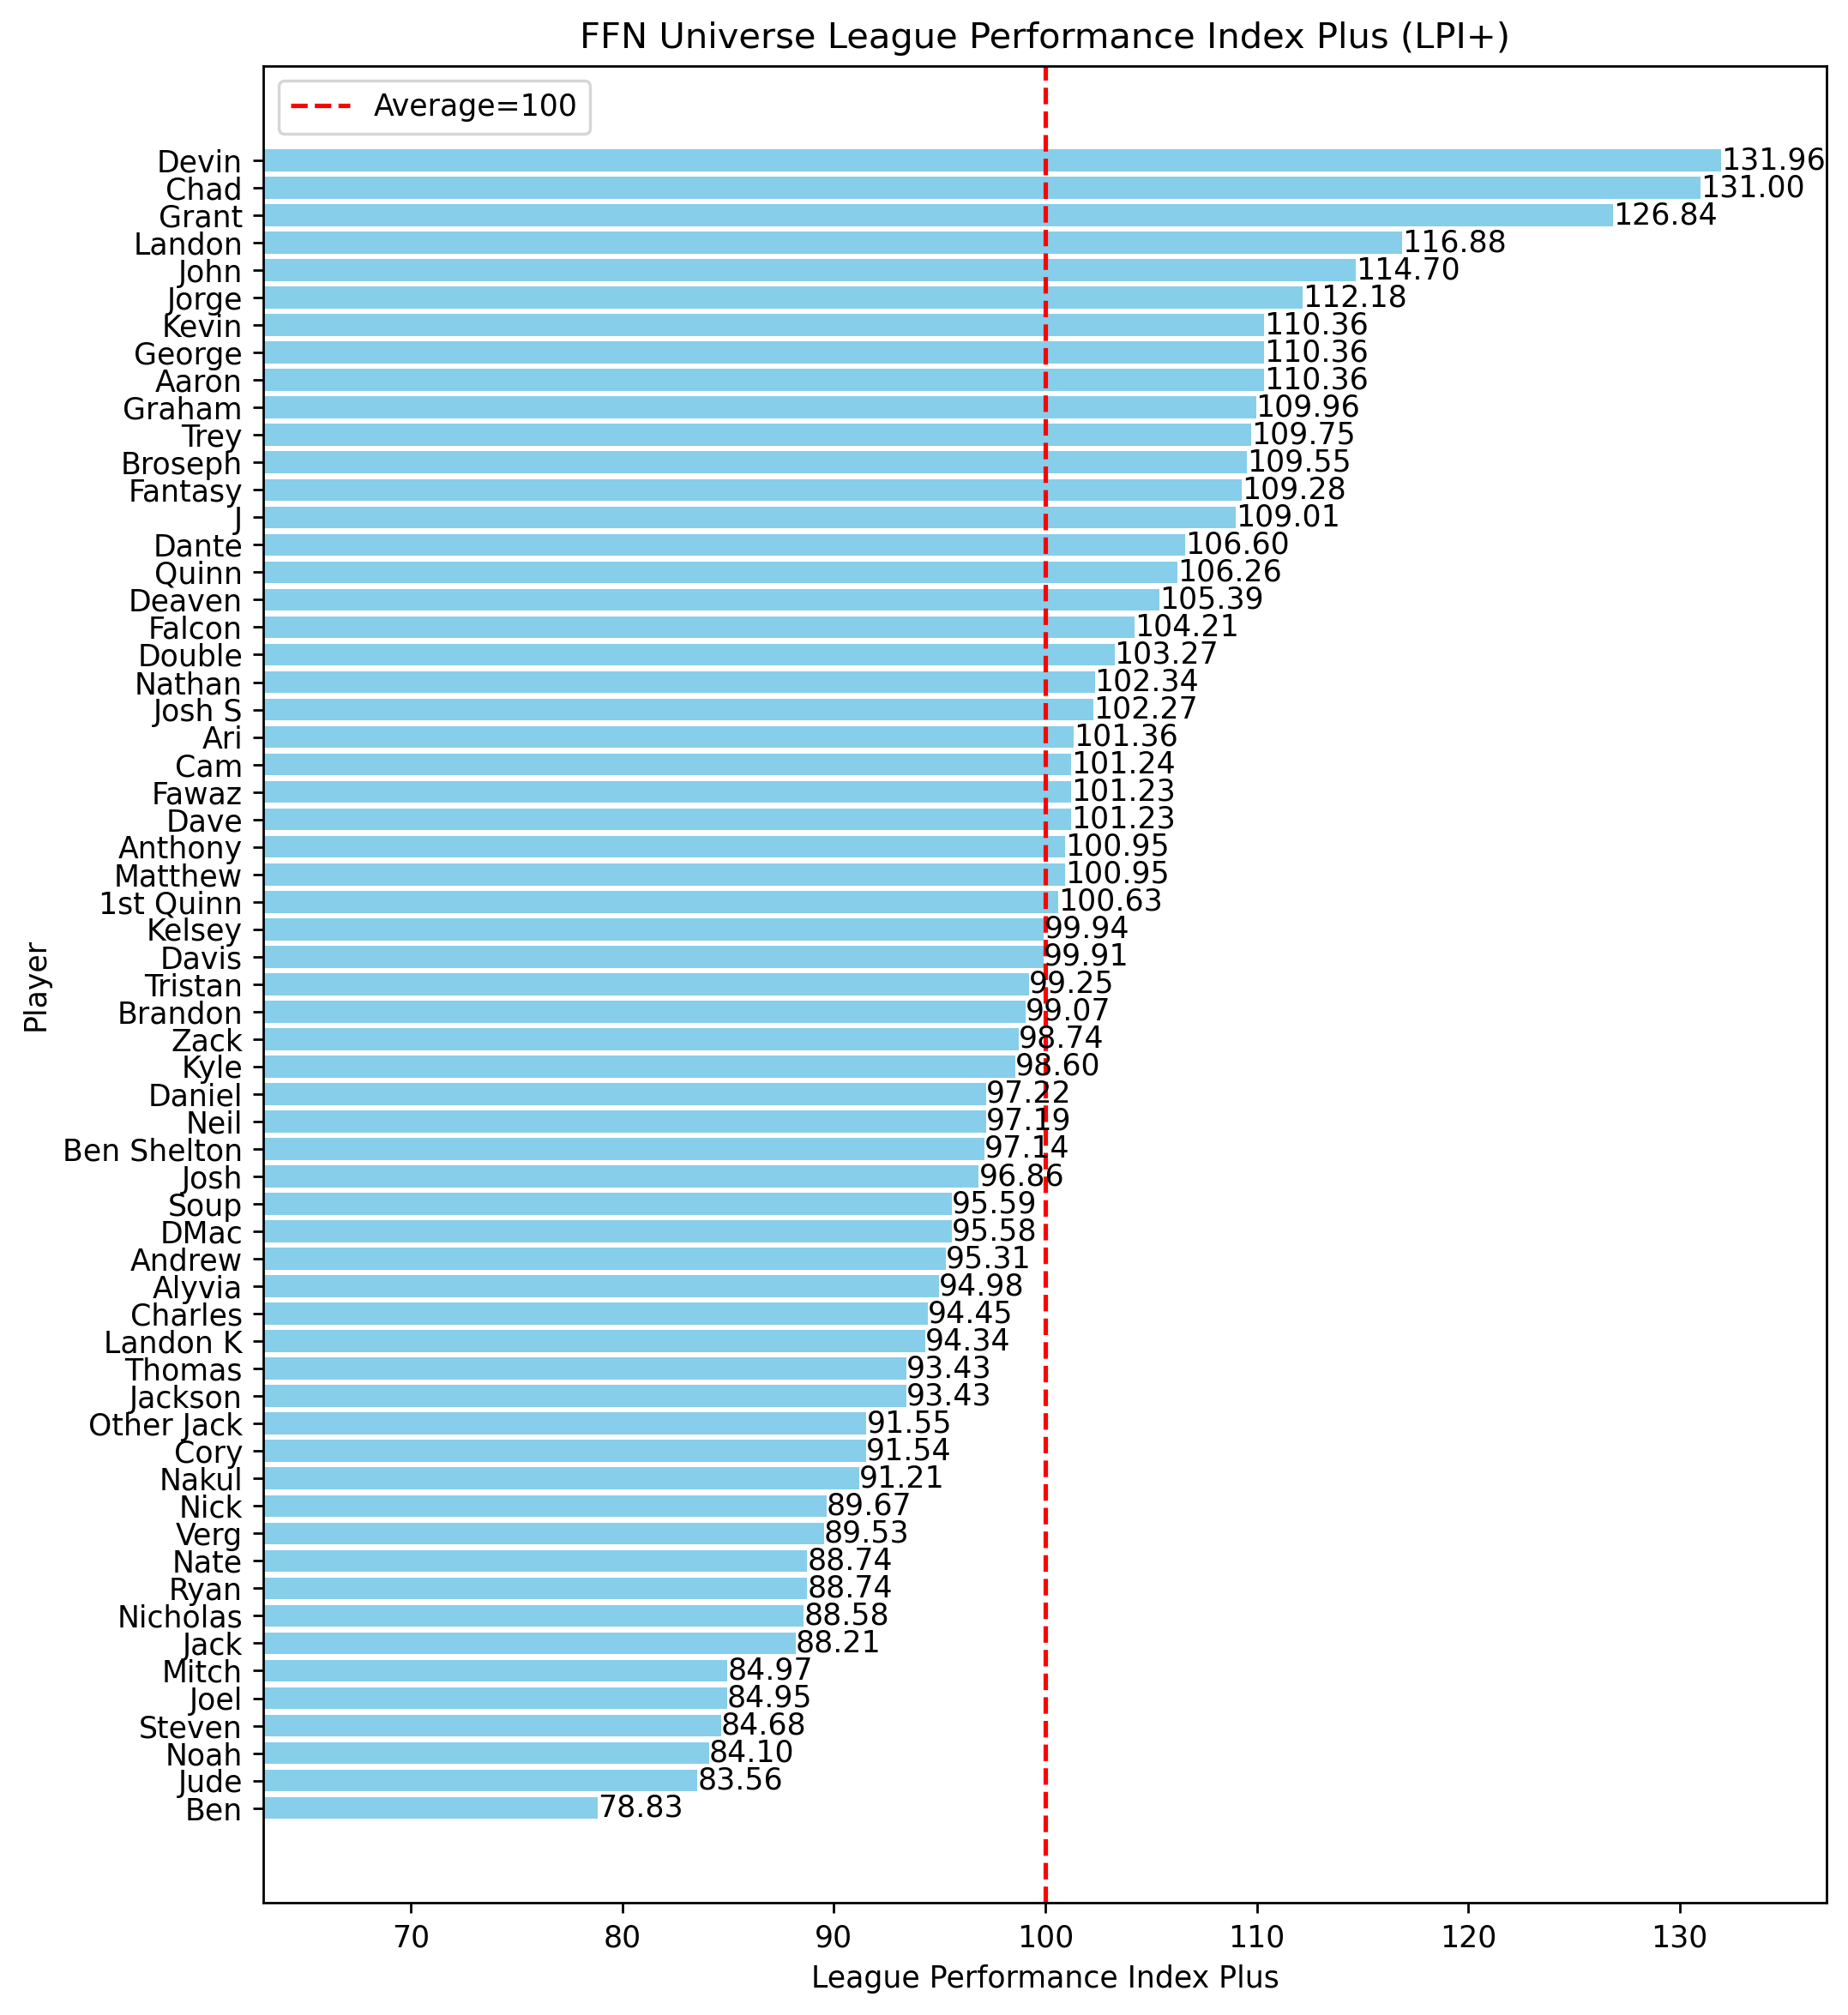

In [49]:
# Reverse the order of the DataFrame
summary_stats_df_sorted_reverse = summary_stats_df[::-1]

# Calculate deviations from 100 (both above and below)
deviation_above = summary_stats_df_sorted_reverse['LPI+'].max() - 100
deviation_below = 100 - summary_stats_df_sorted_reverse['LPI+'].min()

# Find the maximum deviation to ensure symmetry around 100
max_deviation = max(deviation_above, deviation_below)

# Set x-axis limits to center 100 in the plot
x_min = 100 - max_deviation - 5  # Adding a small buffer
x_max = 100 + max_deviation + 5  # Adding a small buffer

plt.figure(figsize=(8.75,9.5), dpi=250)
plt.barh(summary_stats_df_sorted_reverse['Name'], summary_stats_df_sorted_reverse['LPI+'], color='skyblue')
plt.axvline(100, color='red', linestyle='--', label='Average=100')

plt.xlim([x_min, x_max])

plt.xlabel('League Performance Index Plus')
plt.ylabel('Player')
plt.title('FFN Universe League Performance Index Plus (LPI+)')
plt.legend(loc='upper left')

# Adding data labels
for index, value in enumerate(summary_stats_df_sorted_reverse['LPI+']):
    plt.text(value, index, f"{value:.2f}", va='center')

plt.tight_layout()
plt.show()


## Track Performance Over Time

In [68]:
# Function to log current rank and LPI+
def log_rank_and_LPI(df, tracking_df, year, month):
    # Sort by LPI+ and assign ranks
    df_sorted = df.sort_values(by='LPI+', ascending=False).reset_index(drop=True)
    df_sorted['Rank'] = df_sorted.index + 1
    
    # Create column names with year and month suffix
    rank_col = f'Rank_{month}_{year}'
    lpi_col = f'LPI+_{month}_{year}'
    
    # Create a DataFrame for current log with the new columns
    current_log = df_sorted[['ID', 'Rank', 'LPI+']].copy()
    current_log.set_index('ID', inplace=True)
    current_log.rename(columns={'Rank': rank_col, 'LPI+': lpi_col}, inplace=True)
    
    # Merge current log into the tracking DataFrame based on 'ID'
    tracking_df = tracking_df.merge(current_log, how='left', left_on='ID', right_index=True)
    
    return tracking_df

In [69]:
# Usage of logging
tracking_df = log_rank_and_LPI(summary_stats_df, tracking_df, 2024, 7)  # Logging for July 2024
# Reset index to make 'ID' and 'Name' regular columns again
tracking_df.reset_index(inplace=True)
tracking_df

,index,ID,Name,Rank_4_2024,LPI+_4_2024,Rank_7_2024,LPI+_7_2024
0,0,102.0,Devin,1,134.75,1,131.96
1,1,162.0,Chad,2,133.57,2,131.00
2,2,112.0,Grant,3,124.58,3,126.84
3,3,156.0,Landon,4,117.20,4,116.88
4,4,152.0,John,5,115.39,5,114.70
...,...,...,...,...,...,...,...
56,56,167.0,Steven,57,83.45,58,84.68
57,57,114.0,Jack,58,83.20,55,88.21
58,58,116.0,Jude,59,82.26,60,83.56
59,59,150.0,Joel,60,79.73,57,84.95


In [73]:
def calculate_rank_delta(tracking_df, month_1, year_1, month_2, year_2):
    # Create column names based on the inputs
    rank_col_1 = f'Rank_{month_1}_{year_1}'
    rank_col_2 = f'Rank_{month_2}_{year_2}'
    
    # Check if the columns exist in the DataFrame
    if rank_col_1 not in tracking_df.columns or rank_col_2 not in tracking_df.columns:
        raise ValueError(f"One or both of the columns {rank_col_1}, {rank_col_2} do not exist in the DataFrame.")
    
    # Calculate the rank delta
    tracking_df['Rank_Delta'] = tracking_df[rank_col_1] - tracking_df[rank_col_2]
    
    # Sort the DataFrame by the largest delta to the smallest delta
    tracking_df_sorted = tracking_df.sort_values(by='Rank_Delta', ascending=False)
    
    return tracking_df_sorted

In [74]:
# Usage:
sorted_tracking_df = calculate_rank_delta(tracking_df, 4, 2024, 7, 2024)

# Display the sorted DataFrame
sorted_tracking_df

,index,ID,Name,Rank_4_2024,LPI+_4_2024,Rank_7_2024,LPI+_7_2024,Rank_Delta
33,33,109.0,Ari,34,97.62,22,101.36,12
34,34,103.0,Cam,35,97.46,23,101.24,12
55,55,181.0,Nate,56,87.66,52,88.74,4
46,46,172.0,Charles,47,92.20,43,94.45,4
13,13,105.0,Graham,14,109.50,10,109.96,4
...,...,...,...,...,...,...,...,...
9,9,161.0,J,10,110.62,14,109.01,-4
50,50,124.0,Mitch,51,88.73,56,84.97,-5
30,30,125.0,Soup,31,98.58,39,95.59,-8
47,47,164.0,Noah,48,92.19,59,84.10,-11


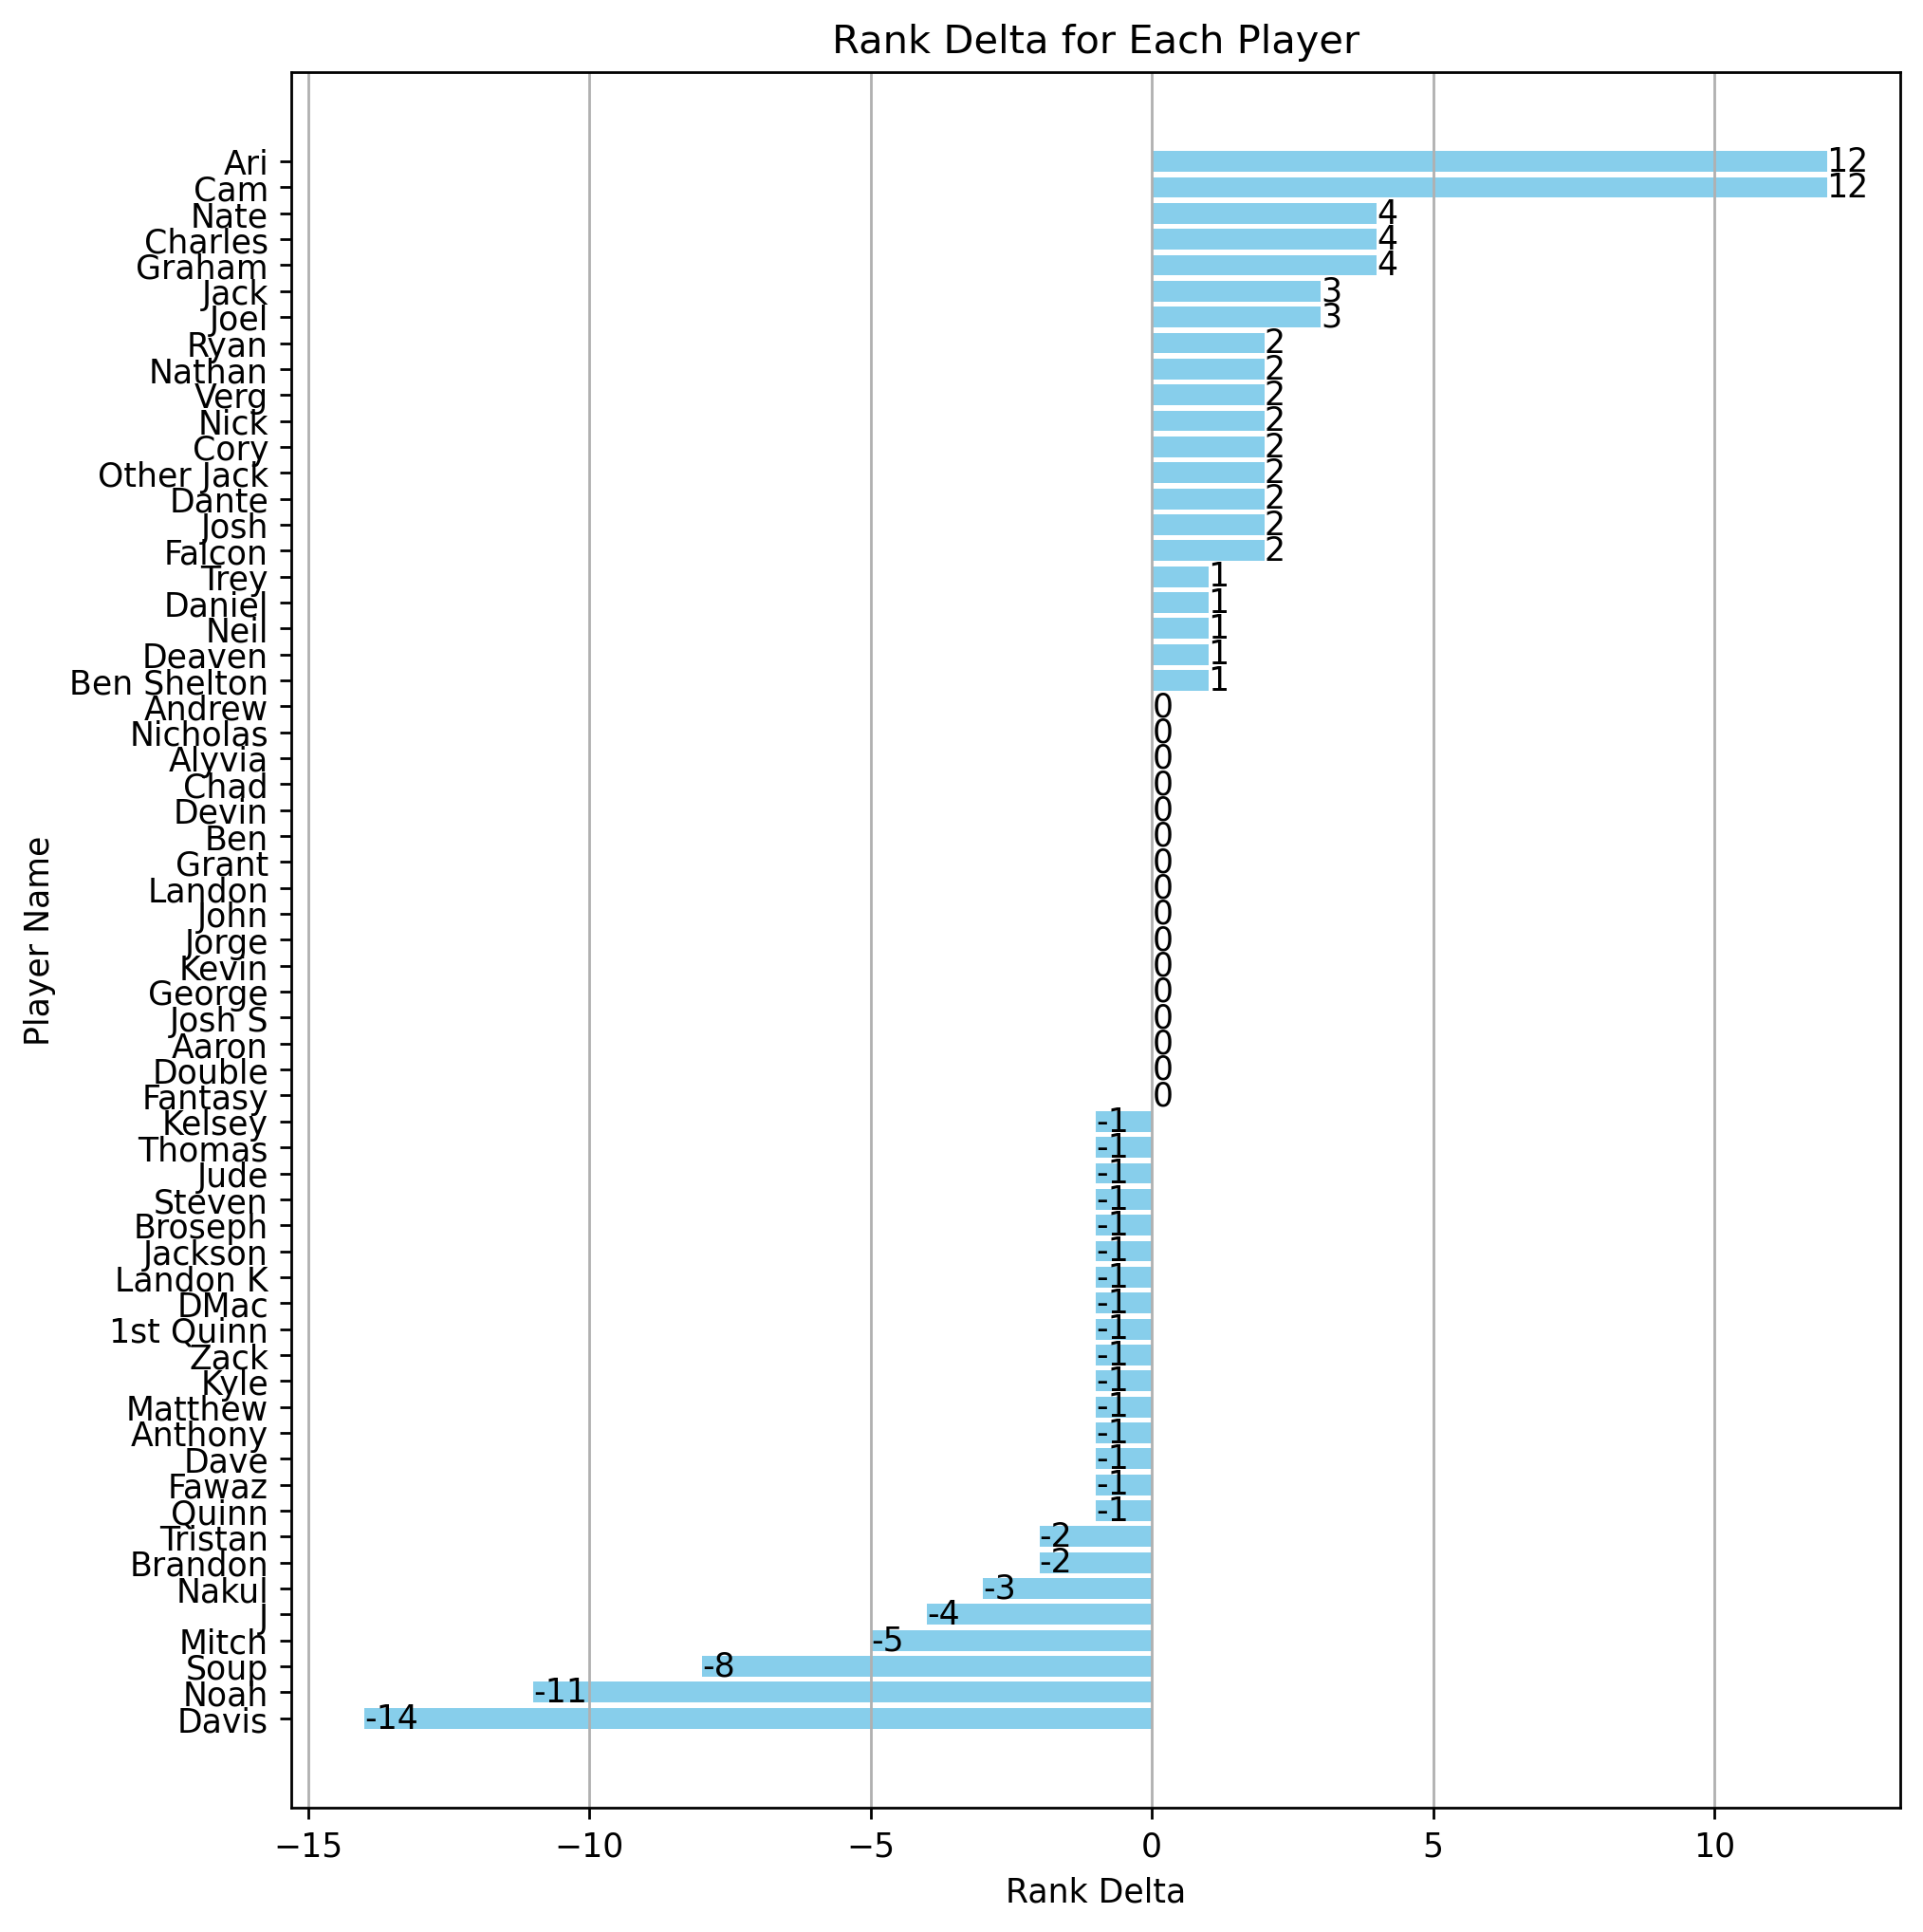

In [78]:
# Create the bar plot
plt.figure(figsize=(8.75,9.5), dpi=250)
bars = plt.barh(sorted_tracking_df['Name'], sorted_tracking_df['Rank_Delta'], color='skyblue')

# Add the actual Rank_Delta values on each bar
for bar, value in zip(bars, sorted_tracking_df['Rank_Delta']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value}', va='center')

plt.xlabel('Rank Delta')
plt.ylabel('Player Name')
plt.title('Rank Delta for Each Player')
plt.gca().invert_yaxis()  # To display the highest delta at the top
plt.grid(axis='x')
plt.show()

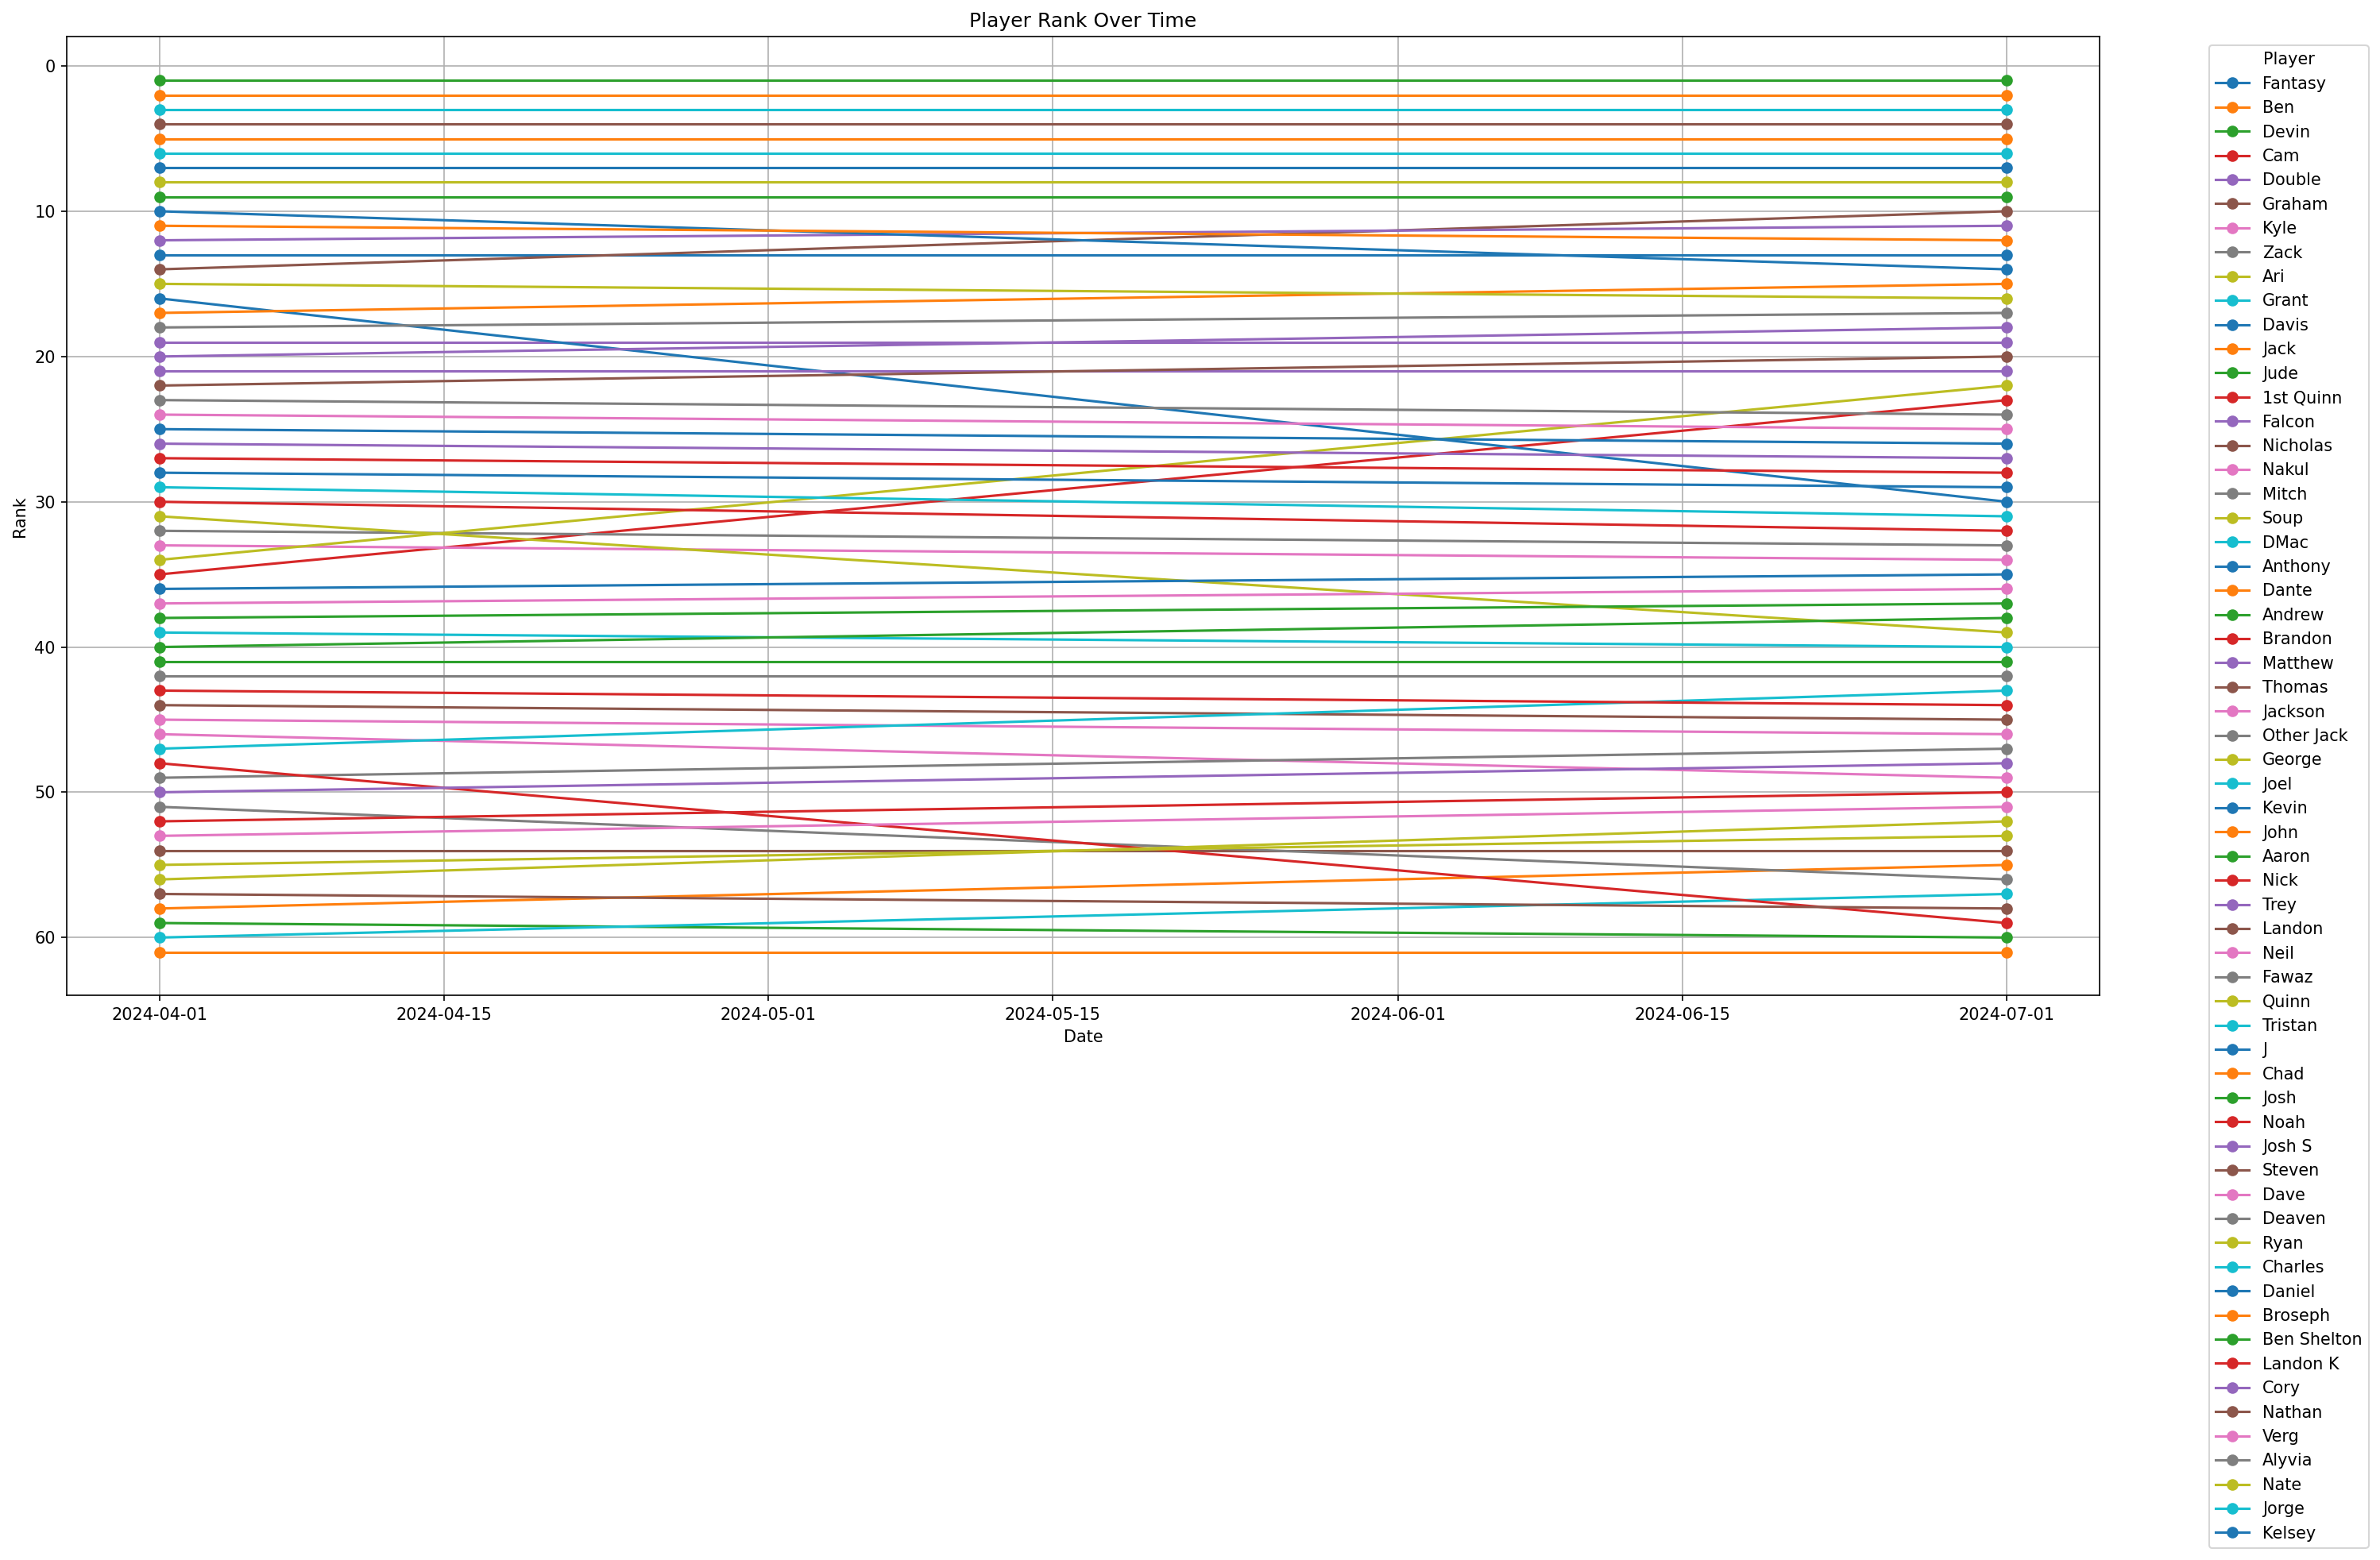

In [70]:
# Convert wide format to long format for plotting
rank_columns = [col for col in tracking_df.columns if 'Rank_' in col]
tracking_long = tracking_df.melt(id_vars=['ID', 'Name'], value_vars=rank_columns, var_name='Month_Year', value_name='Rank')

# Extract month and year from the Month_Year column
tracking_long['Month'] = tracking_long['Month_Year'].apply(lambda x: x.split('_')[1])
tracking_long['Year'] = tracking_long['Month_Year'].apply(lambda x: x.split('_')[2])

# Convert month and year to datetime for sorting
tracking_long['Date'] = pd.to_datetime(tracking_long['Year'] + '-' + tracking_long['Month'] + '-01')

# Sort by ID and Date
tracking_long.sort_values(by=['ID', 'Date'], inplace=True)

plt.figure(figsize=(20, 12), dpi=150)

for player in tracking_long['Name'].unique():
    player_data = tracking_long[tracking_long['Name'] == player]
    plt.plot(player_data['Date'], player_data['Rank'], marker='o', label=player)

plt.xlabel('Date')
plt.ylabel('Rank')
plt.title('Player Rank Over Time')
plt.gca().invert_yaxis()  # Invert y-axis so that rank 1 is at the top
plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Code to develop table for paper

In [86]:
pd.set_option('display.max_rows', None)  # This
summary_stats_df_rounded = summary_stats_df.round(2)
summary_stats_df_reset = summary_stats_df_rounded.reset_index(drop=True)
summary_stats_df_reset.index = summary_stats_df_reset.index + 1
summary_stats_df_reset[['Name', 'Total_Leagues', 'Average_Rank', 'Average_Adjusted_Percentile', 'LPI', 'LPI+']]

,Name,Total_Leagues,Average_Rank,Average_Adjusted_Percentile,LPI,LPI+
1,Devin,51,3.96,1.63,1.56,131.96
2,Chad,23,3.67,1.69,1.55,131.00
3,Grant,9,4.22,1.81,1.50,126.84
4,Landon,11,5.18,1.55,1.38,116.88
5,John,4,6.00,1.75,1.36,114.70
6,Jorge,1,4.00,2.63,1.33,112.18
7,Kevin,2,4.00,1.87,1.31,110.36
8,George,2,4.00,1.87,1.31,110.36
9,Aaron,2,4.00,1.87,1.31,110.36
10,Graham,42,4.96,1.33,1.30,109.96


In [81]:
# Reset the 'display.max_rows' option to its default
pd.reset_option('display.max_rows')

In [83]:

data_str = """
1	Devin	51	3.96	1.63	1.56	131.96
2	Chad	23	3.67	1.69	1.55	131.00
3	Grant	9	4.22	1.81	1.50	126.84
4	Landon	11	5.18	1.55	1.38	116.88
5	John	4	6.00	1.75	1.36	114.70
6	Jorge	1	4.00	2.63	1.33	112.18
7	Kevin	2	4.00	1.87	1.31	110.36
8	George	2	4.00	1.87	1.31	110.36
9	Aaron	2	4.00	1.87	1.31	110.36
10	Graham	42	4.96	1.33	1.30	109.96
11	Trey	10	5.10	1.41	1.30	109.75
12	Broseph	1	2.00	2.33	1.30	109.55
13	Fantasy	3	7.33	1.63	1.29	109.28
14	J	7	4.86	1.43	1.29	109.01
15	Dante	2	5.00	1.63	1.26	106.60
16	Quinn	12	4.92	1.32	1.26	106.26
17	Deaven	1	4.00	1.87	1.25	105.39
18	Falcon	6	4.33	1.32	1.23	104.21
19	Double	37	5.70	1.23	1.22	103.27
20	Nathan	3	8.67	1.32	1.21	102.34
21	Josh S	1	5.50	1.52	1.21	102.27
22	Ari	27	5.74	1.21	1.20	101.36
23	Cam	9	6.06	1.22	1.20	101.24
24	Fawaz	1	6.00	1.40	1.20	101.23
25	Dave	1	6.00	1.40	1.20	101.23
26	Anthony	2	6.50	1.28	1.20	100.95
27	Matthew	2	6.50	1.28	1.20	100.95
28	1st Quinn	1	5.00	1.33	1.19	100.63
29	Kelsey	1	4.00	1.26	1.18	99.94
30	Davis	13	5.77	1.19	1.18	99.91
31	Tristan	6	6.17	1.18	1.18	99.25
32	Brandon	2	7.00	1.17	1.17	99.07
33	Zack	5	6.80	1.16	1.17	98.74
34	Kyle	34	5.91	1.17	1.17	98.60
35	Daniel	2	5.50	1.05	1.15	97.22
36	Neil	2	7.50	1.05	1.15	97.19
37	Ben Shelton	1	5.00	0.94	1.15	97.14
38	Josh	17	6.47	1.13	1.15	96.86
39	Soup	8	6.62	1.09	1.13	95.59
40	DMac	3	7.67	1.01	1.13	95.58
41	Andrew	2	8.00	0.93	1.13	95.31
42	Alyvia	1	9.00	0.70	1.13	94.98
43	Charles	4	5.75	1.00	1.12	94.45
44	Landon K	1	6.00	0.63	1.12	94.34
45	Thomas	2	8.50	0.82	1.11	93.43
46	Jackson	2	8.50	0.82	1.11	93.43
47	Other Jack	2	9.00	0.70	1.08	91.55
48	Cory	1	7.00	0.31	1.08	91.54
49	Nakul	13	6.77	1.02	1.08	91.21
50	Nick	2	9.50	0.58	1.06	89.67
51	Verg	2	13.50	0.57	1.06	89.53
52	Nate	1	12.00	0.00	1.05	88.74
53	Ryan	1	10.00	0.00	1.05	88.74
54	Nicholas	6	6.75	0.87	1.05	88.58
55	Jack	43	6.07	1.02	1.05	88.21
56	Mitch	27	6.30	0.95	1.01	84.97
57	Joel	6	10.08	0.77	1.01	84.95
58	Steven	3	12.33	0.52	1.00	84.68
59	Noah	20	7.05	0.92	1.00	84.10
60	Jude	3	10.00	0.47	0.99	83.56
61	Ben	7	8.14	0.64	0.93	78.83
"""

# Improved regex to handle names with spaces and more than one word
latex_rows = []

# Split the string into lines
data_lines = data_str.strip().split('\n')

# Process each line with regex
for line in data_lines:
    # Match the line format with regex
    match = re.match(r'(\d+)\s+([\w\s]+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', line)
    if match:
        # Format the matched groups into LaTeX table row format
        latex_row = ' & '.join(match.groups()) + r' \\'
        latex_rows.append(latex_row)

# Join all rows into a single string with line breaks
latex_table_content = '\n'.join(latex_rows)

# Print the result or write it to a file
print(latex_table_content)

1 & Devin & 51 & 3.96 & 1.63 & 1.56 & 131.96 \\
2 & Chad & 23 & 3.67 & 1.69 & 1.55 & 131.00 \\
3 & Grant & 9 & 4.22 & 1.81 & 1.50 & 126.84 \\
4 & Landon & 11 & 5.18 & 1.55 & 1.38 & 116.88 \\
5 & John & 4 & 6.00 & 1.75 & 1.36 & 114.70 \\
6 & Jorge & 1 & 4.00 & 2.63 & 1.33 & 112.18 \\
7 & Kevin & 2 & 4.00 & 1.87 & 1.31 & 110.36 \\
8 & George & 2 & 4.00 & 1.87 & 1.31 & 110.36 \\
9 & Aaron & 2 & 4.00 & 1.87 & 1.31 & 110.36 \\
10 & Graham & 42 & 4.96 & 1.33 & 1.30 & 109.96 \\
11 & Trey & 10 & 5.10 & 1.41 & 1.30 & 109.75 \\
12 & Broseph & 1 & 2.00 & 2.33 & 1.30 & 109.55 \\
13 & Fantasy & 3 & 7.33 & 1.63 & 1.29 & 109.28 \\
14 & J & 7 & 4.86 & 1.43 & 1.29 & 109.01 \\
15 & Dante & 2 & 5.00 & 1.63 & 1.26 & 106.60 \\
16 & Quinn & 12 & 4.92 & 1.32 & 1.26 & 106.26 \\
17 & Deaven & 1 & 4.00 & 1.87 & 1.25 & 105.39 \\
18 & Falcon & 6 & 4.33 & 1.32 & 1.23 & 104.21 \\
19 & Double & 37 & 5.70 & 1.23 & 1.22 & 103.27 \\
20 & Nathan & 3 & 8.67 & 1.32 & 1.21 & 102.34 \\
21 & Josh S & 1 & 5.50 & 1.52 & 1.21 &

In [ ]:
# # Initialize a dictionary to store the R^2 values
# r2_values = {}

# # Specify the desired columns for the R^2 analysis
# desired_columns = ['Average_Ranking+', 'Adjusted_Percentile_Ratio', 'Average_Adjusted_Percentile', 'Average_Rank', 'Total_Adjusted_Percentile', 'Total_Leagues']

# # Loop through each of the desired columns and perform linear regression against 'Bayesian_Average'
# for column in desired_columns:
#     # Ensure the column is not 'Bayesian_Average' itself
#     if column != 'Average_Ranking':
#         # Reshape data for sklearn (needs 2D arrays for features)
#         X = summary_stats_df[[column]].values.reshape(-1, 1)
#         y = summary_stats_df['Average_Ranking'].values

#         # Initialize and fit the model
#         model = LinearRegression()
#         model.fit(X, y)

#         # Predict the values
#         y_pred = model.predict(X)

#         # Calculate and store the R^2 value
#         r2_values[column] = r2_score(y, y_pred)

# # Convert the R^2 values dictionary to a DataFrame for better visualization
# r2_df = pd.DataFrame(list(r2_values.items()), columns=['Feature', 'R^2 Value']).sort_values(by='R^2 Value', ascending=False)

# r2_df
